 ## Анализ цен и ассортимента Эльдорадо для Яндекс.Маркета.

### 1. Получение данных, анализ содержимого xml файла.

В данном исследовании представлена выгрузка данных из xml файла, парсинг его с помощью `xml.etree.ElementTree`, создание `DataFrame` для категорий и товаров. Проанализированы различия цен в зависимости от региона для одних видов товаров, наиболее популярные вендоры. Сначала импортируем все библиотеки, необходимые для исследования:

In [1]:
%matplotlib inline
import requests
import pandas as pd
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns

Загрузим данные в оперативную память, т.к. их не много (при желании можно сохранить на диск и затем пользовать уже сохранненый файл). 

In [2]:
# Download and save XML file
el_url = ''
response = requests.get(el_url)

save_file = False
if save_file:
    file_name = 'el_file.xml'
    with open(file_name, 'w') as f:
        f.write(response.text)

Теперь у нас есть `xml` файл, распарсим его с помощью `xml.etree.ElementTree`.

In [3]:
# parse XML file/string
if os.path.exists('el_file.xml'):
    etree = ET.parse('el_file.xml')
    root = etree.getroot()
else:
    root = ET.fromstring(response.text)

Посмотрим количество основных тагов.

In [4]:
main_tags = root.getchildren()
print(main_tags, len(main_tags))

[<Element 'shop' at 0x7f902869aa98>] 1


Посмотрим какие есть таги на уровень ниже

In [5]:
sub_tags = main_tags[0].getchildren()
sub_tags

[<Element 'name' at 0x7f902820b228>,
 <Element 'company' at 0x7f902820b278>,
 <Element 'url' at 0x7f902820b2c8>,
 <Element 'currencies' at 0x7f902820b318>,
 <Element 'categories' at 0x7f902820b3b8>,
 <Element 'offers' at 0x7f9023b66228>]

И длину их подтагов:

In [6]:
length_sub_tags = [len(child) for child in sub_tags]
length_sub_tags

[0, 0, 0, 1, 798, 69321]

Мы видим, что в основном, в наших данных присутствут категории товаров и сами товары. 

In [7]:
categories = sub_tags[-2]
offers = sub_tags[-1]

Посмотрим содержание для первого элемента `categories`:

In [8]:
categories[0], categories[0].items(), categories[0].tag, categories[0].text, len(categories[0].getchildren())

(<Element 'category' at 0x7f902820b408>,
 [('id', '12018'), ('parentId', '12017')],
 'category',
 'Дрели',
 0)

и для `offers`:

In [9]:
offers[0], offers[0].items(), offers[0].tag, offers[0].text, len(offers[0].getchildren())

(<Element 'offer' at 0x7f9023b66278>,
 [('bid', '0'),
  ('type', 'vendor.model'),
  ('id', '41000071_Moskva'),
  ('available', 'true')],
 'offer',
 '\n',
 15)

Получаем, что для первого элемента `offers` мы имеем 15 дочерних тегов. Посмотрим какие там элементы:

In [10]:
offer_child = offers[0].getchildren()
offer_child

[<Element 'url' at 0x7f9023b662c8>,
 <Element 'price' at 0x7f9023b66318>,
 <Element 'currencyId' at 0x7f9023b66368>,
 <Element 'categoryId' at 0x7f9023b663b8>,
 <Element 'picture' at 0x7f9023b66408>,
 <Element 'store' at 0x7f9023b66458>,
 <Element 'pickup' at 0x7f9023b664a8>,
 <Element 'delivery' at 0x7f9023b664f8>,
 <Element 'local_delivery_cost' at 0x7f9023b66548>,
 <Element 'typePrefix' at 0x7f9023b66598>,
 <Element 'vendor' at 0x7f9023b665e8>,
 <Element 'model' at 0x7f9023b66638>,
 <Element 'description' at 0x7f9023b66688>,
 <Element 'sales_notes' at 0x7f9023b666d8>,
 <Element 'manufacturer_warranty' at 0x7f9023b66728>]

Проверим, что мы не упускаем никаких данных, в `categories` нет никаких подтегов (длина детей для каждой категории равна нулю). Для этого сравним длину детей для каждой категории с нулем, и затем возьмем `all`, чтобы проверить что для каждого значения это верно:

In [11]:
all(len(category.getchildren())==0 for category in categories)


True

Аналогично для `offers`, длина детей предполагается равной 15 как и для первого элемента:

In [12]:
all(len(offer.getchildren())==15 for offer in offers)

True

Также посмотрим, что для каждого `child` тега `offers` у нас нет дочерних тегов, т.е. теги содержат только текст (и возможно аттрибуты):

In [13]:
all([all(len(child) == 0 for child in offer.getchildren()) for offer in offers])

True

и также ни одного аттрибута:

In [14]:
all([all(len(child.items()) == 0 for child in offer.getchildren()) for offer in offers])

True

Теперь, когда мы убедились что представляем какие данные имеем создадим `DataFrame` для категорий и товаров.

### 2. Создание `DataFrame` для категорий и товаров и анализ содержимого.

Для категорий, как было представлено выше, у нас два аттрибута для каждого тега. Также в содержании тега есть название категории, поэтому его тоже имеет смысл включить в `DataFrame`. В итоге получаем 3 столбца. Создадим `DataFrame` для категорий с помощью `list comprehension`:

In [15]:
# DataFrame for categories
cat_items = [dict(category.items() + [(category.tag, category.text)]) for category in categories]
df_cats = pd.DataFrame(cat_items)
df_cats.head()

,category,id,parentId
0,Дрели,12018,12017
1,LED телевизоры,2577,2000
2,Аэрогрили,5578,5057
3,Перфораторы,12012,12017
4,3D-очки,2598,2000


Для товаров у нас есть 4 аттрибута. Дочерних тегов имеется 15 штук, которые содержат только текст. В итоге получаем 19 столцов. Здесь воспользуемся `dict`:

In [16]:
# DataFrame for offers
offer_items = []
for offer in offers:
    row_dict = {}
    row_dict.update(dict(offer.items()))
    row_dict.update({(child.tag, child.text) for child in offer.getchildren()})
    offer_items.append(row_dict)

df_offers = pd.DataFrame(offer_items)
df_offers.head()

,available,bid,categoryId,currencyId,delivery,description,id,local_delivery_cost,manufacturer_warranty,model,pickup,picture,price,sales_notes,store,type,typePrefix,url,vendor
0,true,0,1029,RUR,true,Цвет: Оранжевый; Тип: Набор; Состав набора: Си...,41000071_Moskva,460.00,true,MAK 2.10,true,http://www.eldorado.ru/photos/41/new_41000071_...,840.00,None,true,vendor.model,Установочный Набор,http://www.eldorado.ru/cat/detail/41000071/,MYSTERY
1,true,0,1029,RUR,true,Цвет: Оранжевый; Тип: Набор; Состав набора: Си...,41000072_Moskva,460.00,true,MAK 4.08,true,http://www.eldorado.ru/photos/41/new_41000072_...,1999.00,None,true,vendor.model,Установочный Набор,http://www.eldorado.ru/cat/detail/41000072/,MYSTERY
2,true,0,1029,RUR,true,Цвет: Оранжевый; Состав набора: Управляющий ка...,41000130_Moskva,460.00,true,MPRO 5.2,true,http://www.eldorado.ru/photos/41/new_41000130_...,380.00,None,true,vendor.model,Rca Кабель,http://www.eldorado.ru/cat/detail/41000130/,MYSTERY
3,true,0,1122,RUR,true,Емкость: 0.5; Назначение: конденсатор; Кол-во ...,41000146_Moskva,460.00,true,MCP 05,true,http://www.eldorado.ru/photos/41/new_41000146_...,1699.00,None,true,vendor.model,Конденсатор,http://www.eldorado.ru/cat/detail/41000146/,MYSTERY
4,true,0,1122,RUR,true,Цифровой вольтметр: есть; Емкость: 1; Назначен...,41000147_Moskva,460.00,true,MCP 10,true,http://www.eldorado.ru/photos/41/new_41000147_...,1999.00,None,true,vendor.model,Конденсатор,http://www.eldorado.ru/cat/detail/41000147/,MYSTERY


Посмотрим некое `summary` о полученных `DataFrames`, путем получения типов столбцов, количеству уникальных значений и количеству пропусков. Для этого объявим функцию и применим её для каждого `DataFrame`.

In [17]:
def get_overview_counts(df):
    null_summary = df.isnull().sum()
    col_counts = df.apply(lambda x: x.nunique())
    overview_counts = pd.concat([df.dtypes, col_counts, null_summary], axis=1)
    overview_counts.columns = ['type', 'unique', 'isNaN']
    return overview_counts

In [18]:
overview_cats = get_overview_counts(df_cats)
overview_cats

,type,unique,isNaN
category,object,729,0
id,object,798,0
parentId,object,160,0


In [19]:
overview_offers = get_overview_counts(df_offers)
overview_offers

,type,unique,isNaN
available,object,2,0
bid,object,1,0
categoryId,object,582,3
currencyId,object,1,0
delivery,object,1,0
description,object,24193,171
id,object,69321,0
local_delivery_cost,object,6,0
manufacturer_warranty,object,1,0
model,object,26400,0


Из `overview` по `df_offers` мы видимо, что для некоторых колонок мы имеем одно уникальное значение, также в некоторых строках мы имеем пропуски, особенно много в `sales_notes`. Выкинем колонки с одним уникальным значением, т.к. они не имеют смысла для дальнейшего анализа. Также посмотрим их содержимое перед выбросом:

In [20]:
# We could drop columns with 1 unique values:
mask_unique_one = overview_offers.unique == 1
cols_to_drop = mask_unique_one[mask_unique_one].index

# let's see on that cols before drop
df_offers[cols_to_drop].head()

,bid,currencyId,delivery,manufacturer_warranty,type
0,0,RUR,true,true,vendor.model
1,0,RUR,true,true,vendor.model
2,0,RUR,true,true,vendor.model
3,0,RUR,true,true,vendor.model
4,0,RUR,true,true,vendor.model


In [21]:
# now drop that columns
df_offers = df_offers.drop(cols_to_drop, axis=1)

Длина всего `DataFrame` для `offers` 69321, а пропущенных значение для `sales_notes` у нас 69214, т.е. всего чуть большее 100 значений. Посмотрим эти значения и их распределение:

In [22]:
df_offers.sales_notes[df_offers.sales_notes.notnull()].value_counts()

Visa/MasterCard, б/н расчет    101
доступно по предзаказу           6
Name: sales_notes, dtype: int64

Т.к. нашей задачей является распределение цен по различным регионам создадим столбец `city`, показывающим принадлежность какому-либо из регионов. Его можно выделить из столбца `id`. Сначала посмотрим, как он там выглядит.

In [23]:
df_offers['id'].head()

0    41000071_Moskva
1    41000072_Moskva
2    41000130_Moskva
3    41000146_Moskva
4    41000147_Moskva
Name: id, dtype: object

Получаем, что у нас есть числовой `id` для товара, затем через `_` идет название региона. Если мы выбросим числа до `_` и символ `_` мы получим название региона/города. Это можно сделать с помощью `regex` и метода `DataFrame` `str.replace`. Затем посмотрим сколько товаров к какому региону относятся из нашей выборки:

In [24]:
# Let's get items for 3 different city by dropping digits in front of id
df_offers['city'] = df_offers['id'].str.replace('\d+_', '')

# Counts for cities
df_offers['city'].value_counts()

Moskva                                24256
Novosibirskaya_oblast__Novosibirsk    23304
Sankt-Peterburg                       21761
Name: city, dtype: int64

Далее приступим к визуализации.

### 3. Визуализация распределения цен по регионам, наиболее распространненых вендоров.

#### 3.1 Популярность и распределение вендоров.

Начнем с популярности вендоров в нашей подвыборке. Создадим переменную с наибойшей распространенностью.

In [25]:
vendor_counts = df_offers['vendor'].value_counts()
vendor_counts.head()

PHILIPS    1224
BOSCH      1150
SAMSUNG    1141
SONY        983
TESCOMA     961
Name: vendor, dtype: int64

Далее построим график распространенности вендоров в нашей выборке

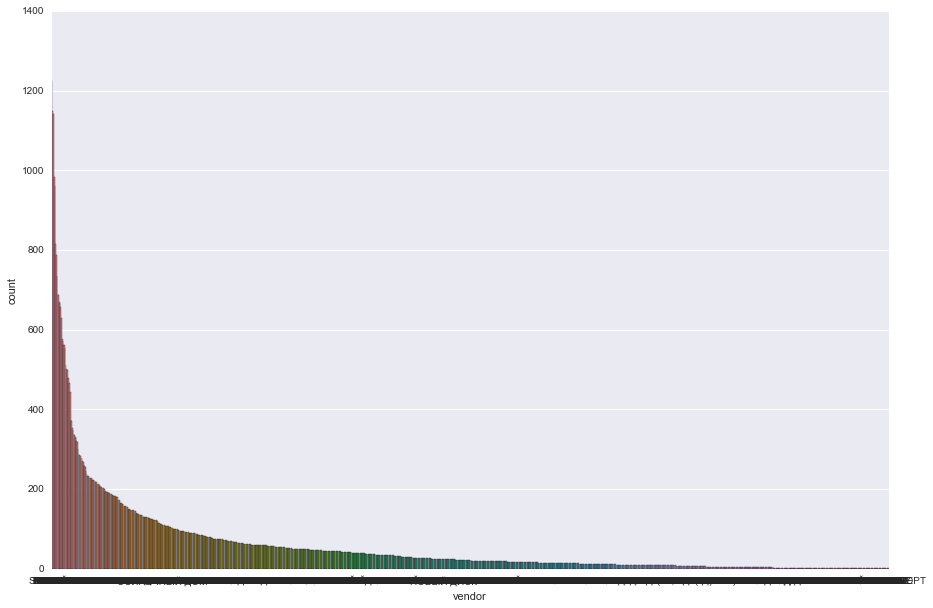

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.countplot(df_offers['vendor'], order=vendor_counts.index, ax=ax)

На представленном выше графике сложно разобрать названия вендоров, т.к. их слишком много. Сократим количество до 50:

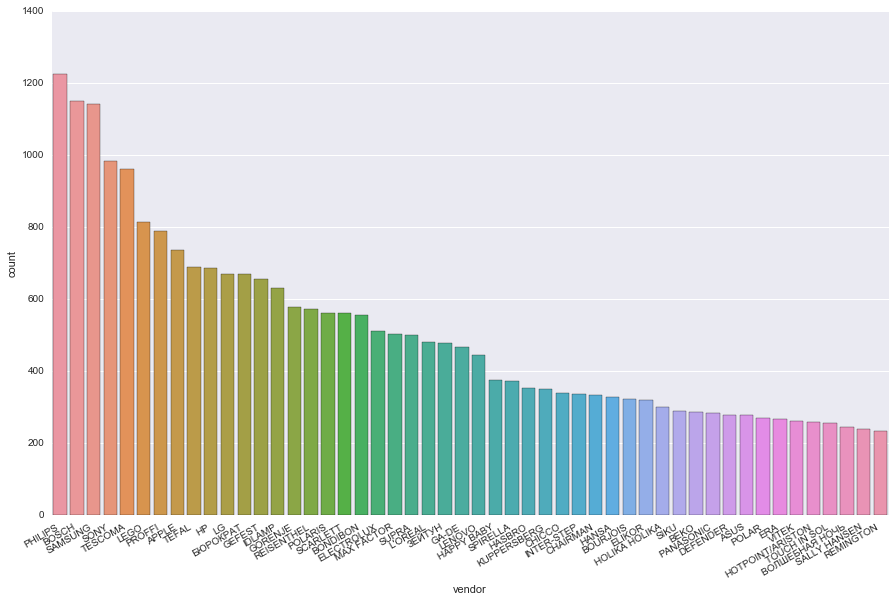

In [27]:
# show 50 most popular vendors
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
cols_to_show = vendor_counts[:50].index
sns.countplot(df_offers.loc[df_offers['vendor'].isin(cols_to_show), 'vendor'], order=cols_to_show, ax=ax)
plt.gcf().autofmt_xdate()

Получаем, что самые распространенные вендоры это `Philips`, `Bosch`, `Samsung`. Теперь посмотроим это распределение по регионам для 10 наиболее популярных вендоров.

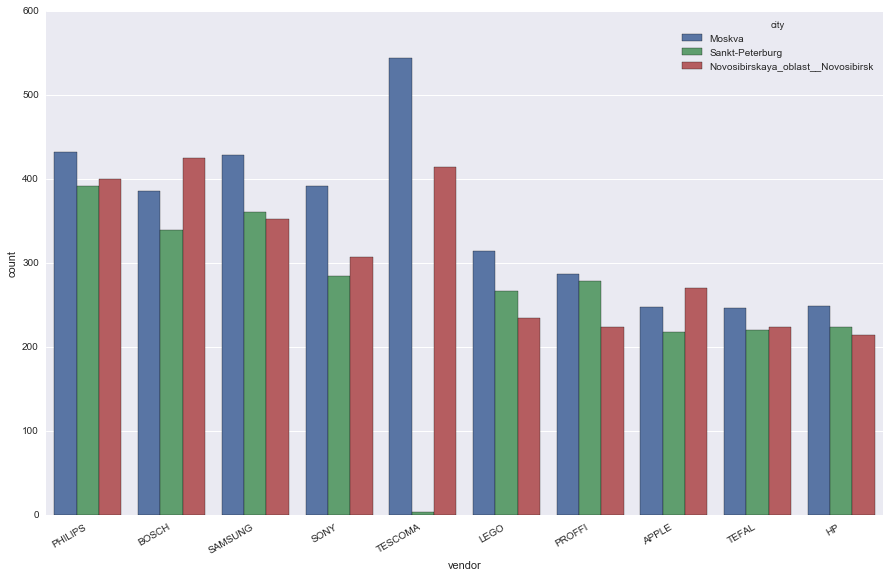

In [28]:
# show 10 most popular vendors per city
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
cols_to_show = vendor_counts[:10].index
sns.countplot(x='vendor', order=cols_to_show, hue='city', data=df_offers.loc[df_offers['vendor'].isin(cols_to_show)], 
              ax=ax)
plt.gcf().autofmt_xdate()

Получаем, что вендоры более менее равномерно распространены по регионам за исключением `Tescoma`, которого не представлено в Санкт-Петербурге

#### 3.2 Распределение категорий товаров.

Далее посмотрим наиболее распространенные категории товаров в нашей выборке. Для этого сгруппируем товары по `categoryId`, возьмем размер каждой группы и затем отсортируем по размеру группы.

In [29]:
# Analyze categories
df_category_size = df_offers.groupby('categoryId').size().reset_index()
df_category_size.columns = ['categoryId', 'size']
df_category_size = df_category_size.sort_values(by='size', ascending=False)
df_category_size.head()

,categoryId,size
319,13190,2732
71,1147,1653
323,13196,1633
235,13023,1421
505,5602,1342


Для получения осмысленных имен категорий склеим наши `DataFrames` для категорий и полученного выше.

In [30]:
df_category_size_names = pd.merge(df_category_size, df_cats, left_on='categoryId', right_on='id', how='left')
df_category_size_names = df_category_size_names[['categoryId', 'size', 'category']]
df_category_size_names = df_category_size_names.sort_values(by='size', ascending=False)
df_category_size_names.head()

,categoryId,size,category
0,13190,2732,Средства по уходу
1,1147,1653,Наушники и гарнитуры
2,13196,1633,Средства по уходу за волосами
3,13023,1421,Конструкторы
4,5602,1342,Вытяжки


Построим распределение по 20 наиболее популярным категориям, для разнообразия построим с помощью `pandas.DataFrame.plot`.

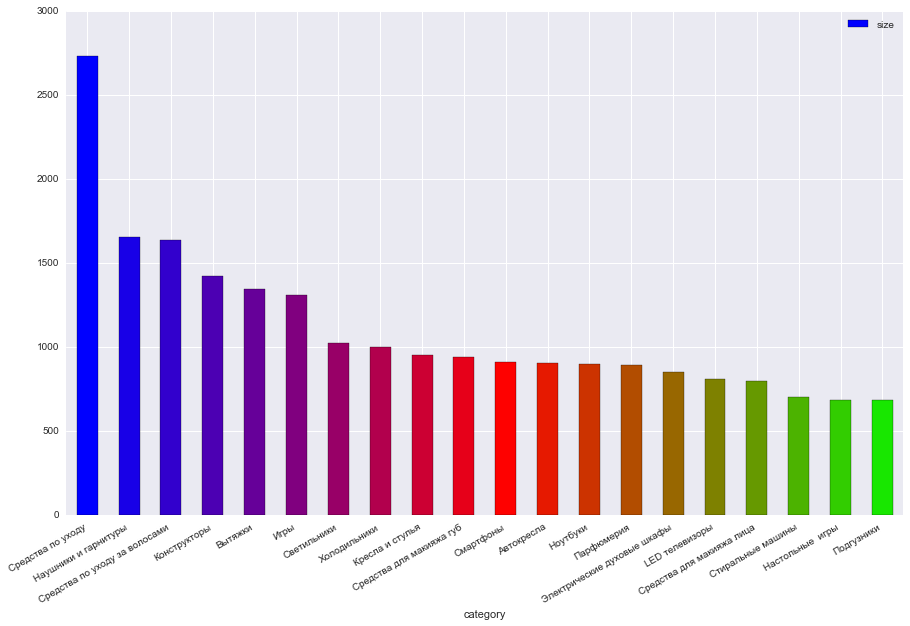

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
cmap=plt.get_cmap("brg")
N = 20
colors = [cmap(i/N) for i in range(N)]
df_category_size_names[:N].plot(x='category', y='size', kind='bar', ax=ax, color=colors)
plt.gcf().autofmt_xdate()

#### 3.3 Анализ категорий по переменной `typePrefix`

Теперь проанализируем категории для переменной `typePrefix`:

In [32]:
df_typePrefix_counts = df_offers['typePrefix'].value_counts()
df_typePrefix_counts.head()

Конструктор              1297
Вытяжка                  1022
Холодильник               971
Смартфон                  901
Наушники с микрофоном     850
Name: typePrefix, dtype: int64

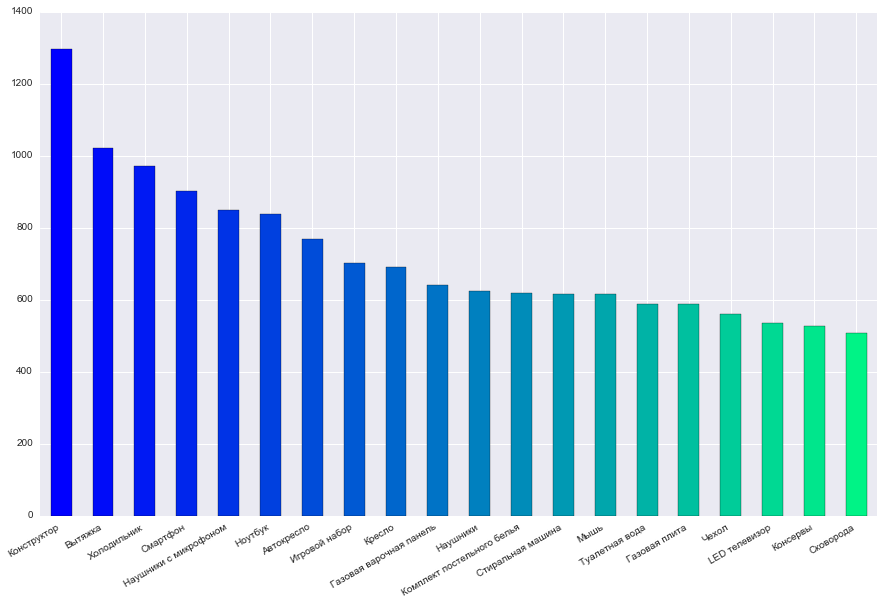

In [33]:
cmap=plt.get_cmap("winter")
N = 20
colors = [cmap(i/N) for i in range(N)]
df_typePrefix_counts[:N].plot(kind='bar', color=colors, figsize=(15,10))
plt.gcf().autofmt_xdate()

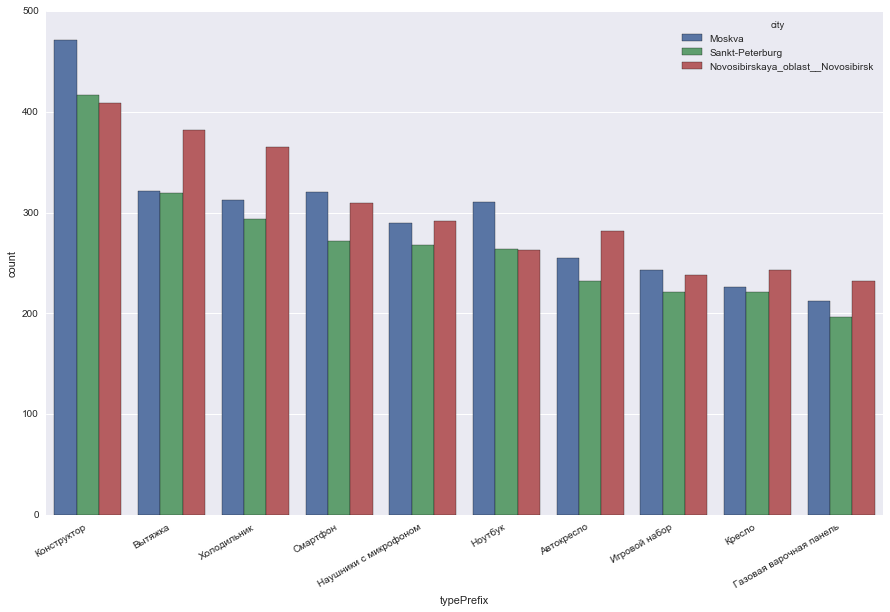

In [34]:
# show 10 most popular type Prefix per city
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
cols_to_show = df_typePrefix_counts[:10].index
sns.countplot(x='typePrefix', order=cols_to_show, hue='city', 
              data=df_offers.loc[df_offers['typePrefix'].isin(cols_to_show)], ax=ax)
plt.gcf().autofmt_xdate()

#### 3.4 Анализ цен и доступности товаров в зависимости от регионов.

Теперь проанализируем как цены на одни и те же товары связаны с регионом. Выделим `DataFrame` для каждого региона:

In [35]:
# Now let's split DataFrame for 3 for each city. 
cols_to_stay = ['url', 'price', 'available', 'typePrefix']
df_mos = df_offers.loc[df_offers['city'] == 'Moskva', cols_to_stay]
df_nov = df_offers.loc[df_offers['city'] == 'Novosibirskaya_oblast__Novosibirsk', cols_to_stay]
df_spb = df_offers.loc[df_offers['city'] == 'Sankt-Peterburg', cols_to_stay]

In [36]:
# rename prices columns according to cities
df_mos.columns = [col + '_mos' for col in df_mos.columns]
df_spb.columns = [col + '_spb' for col in df_spb.columns]
df_nov.columns = [col + '_nov' for col in df_nov.columns]

Далее объединим полученные `DataFrames` для одних товаров с помощью `url`, как показателя одного и того же товара.

In [37]:
# merge three DataFrames
df_merge = (df_mos.merge(df_spb, left_on='url_mos', right_on='url_spb').
    merge(df_nov, left_on='url_mos', right_on='url_nov'))
# replace true and false to True and False
df_merge = df_merge.replace({'true': True, 'false':False})

In [38]:
# drop url after merging
df_merge = df_merge.drop(df_merge.columns[df_merge.columns.str.contains('url')], axis=1)
df_merge = df_merge.drop(['typePrefix_spb', 'typePrefix_nov'], axis=1)
df_merge = df_merge.rename(columns={'typePrefix_mos':'typePrefix'})

Сконвертируем тип колонок `price` к `float` и посмотрим первые строки получившегося `DataFrame`.

In [39]:
price_mask = df_merge.columns.str.contains('price')
df_merge.loc[:, price_mask] = df_merge.loc[:, price_mask].astype(float)
df_merge.head()

,price_mos,available_mos,typePrefix,price_spb,available_spb,price_nov,available_nov
0,840.0,True,Установочный Набор,840.0,True,840.0,True
1,1999.0,True,Установочный Набор,1099.0,True,1550.0,True
2,380.0,True,Rca Кабель,449.0,True,449.0,True
3,1699.0,True,Конденсатор,1699.0,True,1699.0,True
4,950.0,True,Телефон,950.0,True,950.0,True


Проверим, что для каждой позиции цена ненулевая:

In [40]:
# check that every price per item is not null
price_cols = ['price_mos', 'price_nov', 'price_spb']
(df_merge[price_cols] != 0).all(axis=1).all()

True

Создадим колонки для разностей цен

In [41]:
df_merge['diff_mos_nov'] = (df_merge['price_mos'] - df_merge['price_nov'])
df_merge['diff_mos_spb'] = (df_merge['price_mos'] - df_merge['price_spb'])
df_merge['diff_spb_nov'] = (df_merge['price_spb'] - df_merge['price_nov'])
diff_cols = ['diff_mos_nov', 'diff_mos_spb', 'diff_spb_nov']

Построим график разностей цен.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f901bcb3e10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f9019584940>], dtype=object)

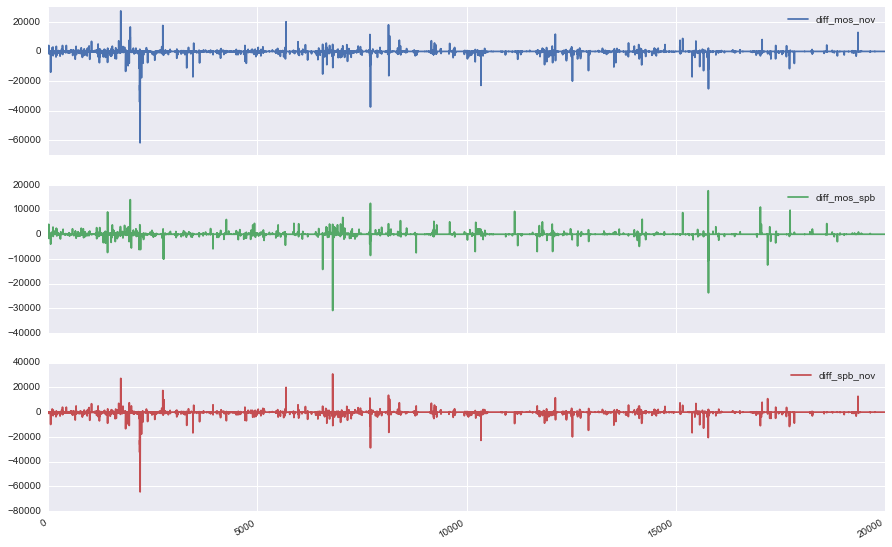

In [42]:
df_merge.plot(y=diff_cols, subplots=True, figsize=(15,10))

Посмотрим суммарное отличие в ценах.

In [43]:
# overall sum price differencies
df_merge[diff_cols].sum()

diff_mos_nov   -2166847.0
diff_mos_spb      73613.0
diff_spb_nov   -2240460.0
dtype: float64

Посмотрим на товары, которые наиболее отличаются по ценам.

In [44]:
N = 10
n_largest_idx = (df_merge[price_cols].max(axis=1) - df_merge[price_cols].min(axis=1)).nlargest(N).index
df_merge.loc[n_largest_idx]

,price_mos,available_mos,typePrefix,price_spb,available_spb,price_nov,available_nov,diff_mos_nov,diff_mos_spb,diff_spb_nov
2198,153200.0,False,ИБП,149950.0,False,214499.0,False,-61299.0,3250.0,-64549.0
2197,104360.0,False,ИБП,104340.0,False,165999.0,False,-61639.0,20.0,-61659.0
2199,109890.0,True,ИБП,109540.0,True,150499.0,False,-40609.0,350.0,-40959.0
7704,72999.0,True,Кофемашина,81579.0,True,110499.0,True,-37500.0,-8580.0,-28920.0
2186,81380.0,False,Батарея для ИБП,83010.0,False,115499.0,False,-34119.0,-1630.0,-32489.0
6801,85619.0,True,Сушильная машина,116489.0,False,85619.0,True,0.0,-30870.0,30870.0
1735,89299.0,True,Кофемашина,89299.0,True,61999.0,True,27300.0,0.0,27300.0
2189,26170.0,False,Батарея для ИБП,26170.0,False,52499.0,False,-26329.0,0.0,-26329.0
15784,51289.0,True,Встраиваемый холодильник,74999.0,False,76499.0,True,-25210.0,-23710.0,-1500.0
10346,56089.0,True,Индукционная варочная панель,56129.0,False,78999.0,True,-22910.0,-40.0,-22870.0


Теперь проанализируем наличие товаров в различных городах

In [45]:
avail_cols = df_merge.columns[df_merge.columns.str.contains('avail')]
df_merge[avail_cols].apply(lambda x: x.value_counts())

,available_mos,available_spb,available_nov
True,19400,16686,12772
False,610,3324,7238


### 4. Краткие выводы

- Проанализировав полученные данные получаем, что наиболее популярными вендорами в магазине Эльдорадо являются PHILIPS, BOSCH, SAMSUNG, SONY. 
- Цены на товары, как это не странно, больше всего в Новосибирске. Возможно это какие выбросы в данных. Исходя из 10 наиболее различающихся товаров, в Новосибирске ИБП (на основании `typePrefix`) значительно дороже чем в Москве и Санкт-Петербурге.
- Наиболее популярные категории товаров на основании переменной `typePrefix`: Конструктор, Вытяжка, Холодильник, Смартфон, Наушники с микрофоном. 
- Наиболее популярные категории товаров: Средства по уходу, Наушники и гарнитуры, Средства по уходу за волосами, Конструкторы, Вытяжки.
- Наличие товаров больше в Москве. В Новосибирске отсутствует чуть более трети.